Topic:        Challenge Set 1
Subject:      Explore MTA turnstile data
Date:         xx/xx/xxxx
Name:         student name
Worked with:  other students' name
Location:     nyc17_ds10/student_submissions/challenges/01-mta/shaikh_reshama/challenge_set_1_reshama.ipynb

In [1]:
import sys
print("Python Version:", sys.version)

Python Version: 3.7.4 (default, Aug 13 2019, 15:17:50) 
[Clang 4.0.1 (tags/RELEASE_401/final)]


### Challenge 1

In [2]:
import pandas as pd
import datetime

In [3]:
def clean_data(df):
    
    df.columns = ['C/A','UNIT','SCP','STATION','LINENAME',\
              'DIVISION','DATE','TIME','DESC','ENTRIES','EXITS']
    
    df['converted_time'] = pd.to_datetime(df['DATE']+' '+df['TIME'])
    df['turnstiles'] = df['C/A'] + '-' + df['UNIT'] + '-' + df['SCP'] + '-' + df['STATION']
    
    df_sorted = df.sort_values(['turnstiles', 'converted_time'])
    
    turnstile_df = df_sorted.groupby('turnstiles')
    df_sorted['entries_diff'] = turnstile_df['ENTRIES'].diff()
    df_sorted['exits_diff'] = turnstile_df['EXITS'].diff()
    
    df_sorted['entries_diff'] = df_sorted['entries_diff'].fillna(0)
    df_sorted['exits_diff'] = df_sorted['exits_diff'].fillna(0)
    
    
    return df_sorted

In [16]:
def remove_outliers(df_sorted):
    # calculates IQR for entries_diff
    Q3 = df_sorted['entries_diff'].quantile(0.75) 
    Q1 = df_sorted['entries_diff'].quantile(0.25)
    IQR = Q3 - Q1
    # calculates IQR range using outliers 
    IQR_range = (Q1 - 1.5 * IQR, Q3 + 1.5 * IQR)
    IQR_range
    # removes values outside of lower and upper bounds
    df_sorted = df_sorted[df_sorted['entries_diff'].between(IQR_range[0], IQR_range[1])]
    # repeats process for exits_diff
    Q3_2 = df_sorted['exits_diff'].quantile(0.75) 
    Q1_2 = df_sorted['exits_diff'].quantile(0.25)
    IQR_2 = Q3_2 - Q1_2
    IQR_range_2 = (Q1_2 - 1.5 * IQR, Q3_2 + 1.5 * IQR)
    IQR_range_2
    df_sorted = df_sorted[df_sorted['exits_diff'].between(IQR_range_2[0], IQR_range_2[1])]
    return df_sorted

In [1]:
import re
def combine_datasets(df1):

    """This function will perform a left merge on the 'STATION' column
    from the turnstile.txt and the 'Stop Name' column from the stations.csv.

    Parameters:
        df1 (pandas.DataFrame): specifically, mta turnstile.txt dataframe

    Returns:
        merged_df (pandas.DataFrame): a new dataframe of mta turnstile.txt 
        and stations.csv
    """
    station_df = pd.read_csv('http://web.mta.info/developers/data/nyct/subway/Stations.csv')
    # drop duplicates as vinny suggested for stop name column 
    station_df.drop_duplicates(subset ="Stop Name", inplace=True)
    # format columns for merge in both datasets
    station_df['station_formatted'] = station_df['Stop Name'].map(lambda x: re.sub(r'\W+', '', x.lower()))
    df1['station_formatted'] = df1.STATION.map(lambda x: re.sub(r'\W+', '', x.lower()))
    
    # this is for debugging...
    a = set(df1.station_formatted.sort_values().unique())
    b = set(test2.station_formatted.sort_values().unique())
    print('number of non matching station names between datasets', len(a-b))
    print('number of matching station names between datasets', len(a&b))
    
    combined_df = df1.merge(station_df, how='left').drop(columns=['station_formatted'])
    print('number of na values in a single new column after left merge',\
          combined_df.Borough.isna().sum())
    
    return combined_df

In [18]:
df1 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190803.txt')
df2 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190810.txt')
df3 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190817.txt')
df4 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190824.txt')
df5 = pd.read_csv('http://web.mta.info/developers/data/nyct/turnstile/turnstile_190831.txt')
df_sorted = remove_outliers(clean_data(df1))


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt


Text(0.5, 0.98, 'Daily Entries For Turnstile A002-R051-02-00-01-59 ST')

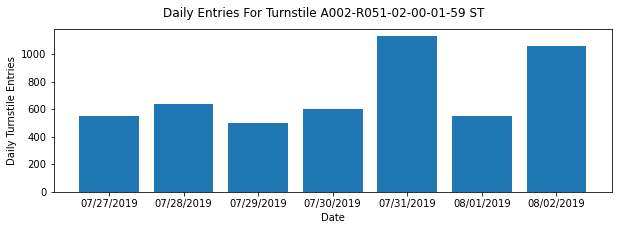

In [20]:
#Filter DF for data of just 1 turnstile, sort by date
single_turnstile = df_sorted[df_sorted.turnstiles == 'A002-R051-02-00-01-59 ST']
single_turnstile_sorted = single_turnstile.groupby('DATE').sum()

#Plot daily entries for 1 turnstile
plt.figure(figsize=(10,3))
x = single_turnstile_sorted.index
y = single_turnstile_sorted['entries_diff']
plt.bar(x, y)
plt.xlabel('Date')
plt.ylabel('Daily Turnstile Entries')
plt.suptitle('Daily Entries For Turnstile A002-R051-02-00-01-59 ST'  )

In [ ]:
### question 5 

In [67]:
df_sorted['turnstile_units'] = df_sorted['C/A'] + '-' + df_sorted['UNIT'] + '-' + df_sorted['STATION']
test = df_sorted.groupby(['turnstile_units', 'DATE'])[['entries_diff', 'exits_diff']].sum().reset_index()
test

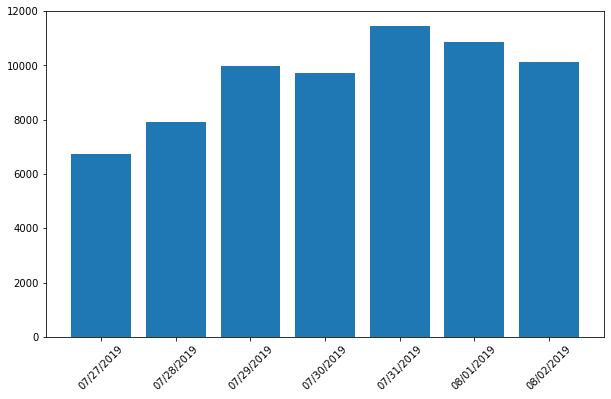

In [64]:
# challenge 6 and 7 plot the daily time series for a station...
plt.figure(figsize=[10,6])
station1 = test[test.turnstile_units == 'R159-R164-66 ST-LINCOLN']
plt.bar(station1.DATE, station1.entries_diff + station1.exits_diff)
plt.xticks(rotation=45)
plt.show()


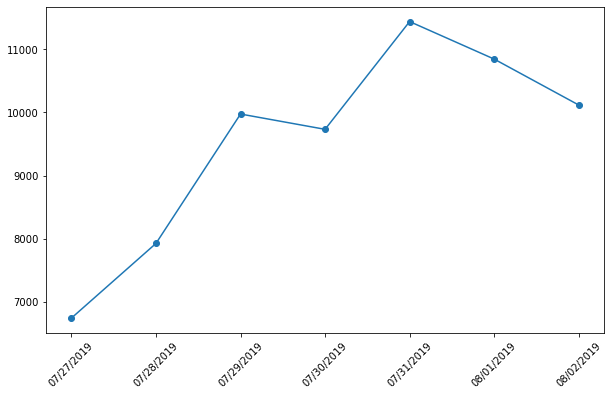

In [66]:
plt.figure(figsize=[10,6])
plt.plot(station1.DATE, station1.entries_diff + station1.exits_diff)
plt.scatter(station1.DATE, station1.entries_diff + station1.exits_diff)
plt.xticks(rotation=45)
plt.show()

In [21]:
# df = pd.concat([df1, df2, df3, df4, df5])

### Challenge 2

In [24]:
# df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1032369 entries, 0 to 205262
Data columns (total 14 columns):
 #   Column                                                                Non-Null Count    Dtype         
---  ------                                                                --------------    -----         
 0   C/A                                                                   1032369 non-null  object        
 1   UNIT                                                                  1032369 non-null  object        
 2   SCP                                                                   1032369 non-null  object        
 3   STATION                                                               1032369 non-null  object        
 4   LINENAME                                                              1032369 non-null  object        
 5   DIVISION                                                              1032369 non-null  object        
 6   DATE               

In [25]:
# df['converted_time'] = pd.to_datetime(df['DATE']+' '+df['TIME'])

In [26]:
# df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,converted_time,turnstiles,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,00:00:00,REGULAR,7148288,2418935.0,2019-07-27 00:00:00,A002-R051-02-00-00-59 ST,NaN
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,04:00:00,REGULAR,7148306,2418939.0,2019-07-27 04:00:00,A002-R051-02-00-00-59 ST,NaN
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,08:00:00,REGULAR,7148326,2418975.0,2019-07-27 08:00:00,A002-R051-02-00-00-59 ST,NaN
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,12:00:00,REGULAR,7148441,2419042.0,2019-07-27 12:00:00,A002-R051-02-00-00-59 ST,NaN
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,07/27/2019,16:00:00,REGULAR,7148647,2419101.0,2019-07-27 16:00:00,A002-R051-02-00-00-59 ST,NaN


In [27]:
# sort_df = df.groupby(['C/A', 'UNIT', 'SCP', 'STATION', 'DATE']).min()

In [35]:
# sort_df["NEW_ENTRIES"] = sort_df.ENTRIES.diff()

In [42]:
# sort_df.rename(columns={'EXITS                                                               ':'EXITS'}, inplace=True)

In [43]:
# sort_df["NEW_EXITS"] = sort_df.EXITS.diff()

In [30]:
# sort_df.head(30)